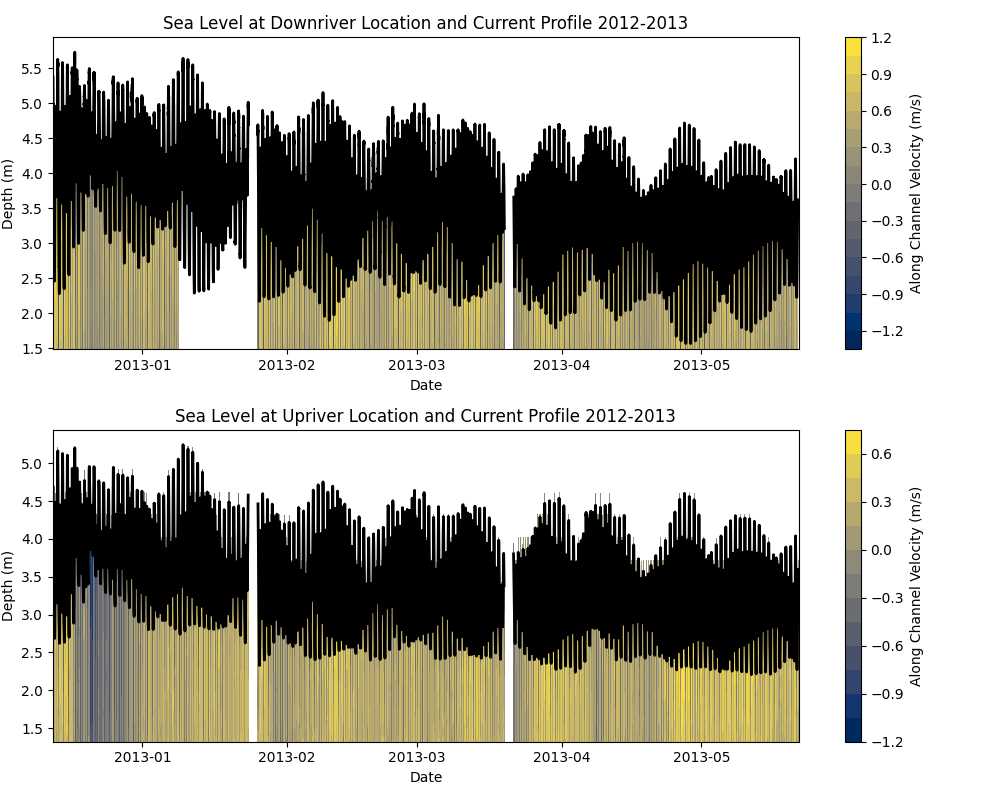

'\nfigHm2 = go.Figure(data = go.Heatmap(z=AquadoppDictUResized, x=matDockDF[\'DN\'], y=(matAquadoppZDF[\'z\'] + 0.4100), colorscale=\'cividis\', colorbar=dict(title="Along Channel Velocity (m/s)"), zsmooth = \'best\'))\n#figHm2 = go.Figure(data = go.Contour(z=AquadoppDictUResized))\nfigHm2.add_trace(go.Scatter(x = matDockDF[\'DN\'], y = matDockDF[\'Hur\'], mode = \'lines\', name = \'Upriver Sea Level\', line=dict(color = \'black\')))\nfigHm2.update_layout(title_text="Sea Level at Upriver Location and Current Profile 2013-2014")\nfigHm2.update_layout(xaxis_title = "Date", yaxis_title = "Depth (m)")\nfigHm2.show()   '

In [2]:
# private dock midestuary
# Data points every 5 minuetes
# HDR is sea level

import pandas as pd
import scipy.io as sio
from scipy import interpolate
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
%matplotlib ipympl

def Array_To_DataFrame(matDF, varName) :
    npArray = np.array([])
    for i in range (matDF[varName].shape[0]) :
        npArray = np.concatenate((npArray, matDF[varName][i].flatten()))
    return npArray
def matFile_To_DF(matFile) :
    tempDF = sio.loadmat(matFile)
    matDataMidFiltered = {}
    for dictKey in tempDF.keys() :
        if isinstance(tempDF[dictKey], np.ndarray) :
            if tempDF[dictKey].shape[0] > 1 :
                matDataMidFiltered.update({dictKey : tempDF[dictKey]})

    matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})
    return matMidDF

def matFileCurrent_To_DF(matFile) :
    tempDF = sio.loadmat(matFile)
    matDataMidFiltered = {}
    for dictKey in tempDF.keys() :
        if isinstance(tempDF[dictKey], np.ndarray) :
            if tempDF[dictKey].shape[0] > 1 and tempDF[dictKey].shape[1] > 1 :
                for i in range(tempDF[dictKey].shape[0]) :
                    matDataMidFiltered.update({dictKey + '_z_' + str(i) : tempDF[dictKey][i]})
            elif dictKey == 'DN':
                matDataMidFiltered.update({dictKey : tempDF[dictKey]})

    matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})
    matMidZ = pd.DataFrame({'z' : tempDF['Z'].flatten()})
    return (matMidDF, matMidZ, tempDF)

# import files for 2012-2013 and extract sea level data
matDockDF = matFile_To_DF('2012-13\\P_processed_01.mat')
# import downriver current data
(matADCPDF, matADCPZDF, ADCPDict) = matFileCurrent_To_DF('2012-13\\adcp_2012_13.mat')
(matAquadoppDF, matAquadoppZDF, AquadoppDict) = matFileCurrent_To_DF('2012-13\\aquadopp_2012_13.mat')
#mat lab date origin
#print(ADCPDict['Z'])
ADCPDictUResized = np.resize(ADCPDict['U'], (ADCPDict['U'].shape[0], 46099))
AquadoppDictUResized = np.resize(AquadoppDict['U'], (AquadoppDict['U'].shape[0], 46099))

for i in range(ADCPDict['U'].shape[0]) :
    #print(AquadoppDict['U'][i])
    #print(AquadoppDict['DN'])
    #print(np.interp(matDockDF['DN'], AquadoppDict['DN'].flatten(), AquadoppDict['U'][i]))
    tempNp = np.interp(matDockDF['DN'], ADCPDict['DN'].flatten(), ADCPDict['U'][i])
    ADCPDictUResized[i] = tempNp

for i in range(AquadoppDict['U'].shape[0]) :
    #print(AquadoppDict['U'][i])
    #print(AquadoppDict['DN'])
    #print(np.interp(matDockDF['DN'], AquadoppDict['DN'].flatten(), AquadoppDict['U'][i]))
    tempNp = np.interp(matDockDF['DN'], AquadoppDict['DN'].flatten(), AquadoppDict['U'][i])
    AquadoppDictUResized[i] = tempNp

#mat lab date origin
origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')

#convert DN to datetime
matDockDF['DN'] = (matDockDF['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')
ADCPDict['DN'] = (ADCPDict['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')
AquadoppDict['DN'] = (AquadoppDict['DN'] * np.timedelta64(24*3600000, 'ms') + origin + np.timedelta64(500, 'ms')).astype('datetime64[s]')

seaLevelfig = px.line(x = matDockDF['DN'], y = [matDockDF['Hdr'], matDockDF['Hur']], color_discrete_sequence= ["black", "blue"], title = "Sea Level")
seaLevelFigLabel = ['Downriver Sea Level', 'Upriver Sea Level']
for idx in range(len(seaLevelFigLabel)):
    seaLevelfig.data[idx].name = seaLevelFigLabel[idx]
    seaLevelfig.data[idx].hovertemplate = 'variable=' + seaLevelFigLabel[idx] + '<br>x=%{x}<br>value=%{y}<extra></extra>'
    seaLevelfig.data[idx].legendgroup = seaLevelFigLabel[idx]


seaLevelfig.update_layout(title=dict(text= "Sea Level for 2012-2013", font=dict(size=25)))
seaLevelfig.update_xaxes(tickangle=30)
seaLevelfig.update_xaxes(rangeslider_visible=True)
seaLevelfig.update_xaxes(range = [pd.Timestamp('2012-12-11'),pd.Timestamp('2013-05-26')])
seaLevelfig.update_layout(xaxis_title="Date", yaxis_title="Sea Level (m)", legend_title="Locations")
#seaLevelfig.show()

# testing heat maps / plotting under the curve
'''
# Align and interpolate U to match dock time series
plt.cla()
plt.contourf(matDockDF['DN'], (matADCPZDF['z'] + 0.4367), ADCPDictUResized, levels = 15, cmap = 'cividis')
plt.colorbar(label = 'Along Channel Velocity (m/s)')
plt.plot(matDockDF['DN'], matDockDF['Hdr'], linewidth=2, label='SeaLevel at Downriver Location', color = 'black')
plt.title('Sea Level at Downriver Location and Current Profile 2012-2013')
plt.xlabel('Date')
plt.ylabel('Depth (m)')
plt.show()
'''
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
plt.subplots_adjust(hspace=3)
contourPlot = ax1.contourf(matDockDF['DN'], (matADCPZDF['z'] + 0.4367), ADCPDictUResized, levels = len(matADCPZDF['z']), cmap = 'cividis')
fig.colorbar(contourPlot, ax = ax1, label = 'Along Channel Velocity (m/s)')
ax1.plot(matDockDF['DN'], matDockDF['Hdr'], linewidth=2, label='SeaLevel at Downriver Location', color = 'black')
ax1.set_title('Sea Level at Downriver Location and Current Profile 2012-2013')
ax1.set_xlabel('Date')
ax1.set_ylabel('Depth (m)')

contourPlot2 = ax2.contourf(matDockDF['DN'], (matAquadoppZDF['z'] + 0.4100), AquadoppDictUResized, levels = len(matAquadoppZDF['z']), cmap = 'cividis')
fig.colorbar(contourPlot2, ax = ax2, label = 'Along Channel Velocity (m/s)')
ax2.plot(matDockDF['DN'], matDockDF['Hur'], linewidth=2, label='SeaLevel at Upriver Location', color = 'black')
ax2.set_title('Sea Level at Upriver Location and Current Profile 2012-2013')
ax2.set_xlabel('Date')
ax2.set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()
'''
figHm = go.Figure(data = go.Heatmap(z=ADCPDictUResized, x=matDockDF['DN'], y=(matADCPZDF['z'] + 0.4367), colorscale='cividis', colorbar=dict(title="Along Channel Velocity (m/s)"), zsmooth = 'best'))
#figHm = go.Figure(data = go.Contour(z=ADCPDictUResized, x= matDockDF['DN'], y = (matADCPZDF['z'] + 0.4367), colorscale='cividis', colorbar=dict(title="Along Channel Velocity (m/s"), ncontours = 5))
figHm.add_trace(go.Scatter(x = matDockDF['DN'], y = matDockDF['Hdr'], mode = 'lines', name = 'Downriver Sea Level', line=dict(color='black')))
figHm.update_layout(title_text="Sea Level at Downriver Location and Current Profile 2013-2014")
figHm.update_xaxes(range=["2012-12-11", "2012-12-14"])
figHm.update_layout(xaxis_title = "Date", yaxis_title = "Depth (m)")
figHm.show()
'''
'''
figHm2 = go.Figure(data = go.Heatmap(z=AquadoppDictUResized, x=matDockDF['DN'], y=(matAquadoppZDF['z'] + 0.4100), colorscale='cividis', colorbar=dict(title="Along Channel Velocity (m/s)"), zsmooth = 'best'))
#figHm2 = go.Figure(data = go.Contour(z=AquadoppDictUResized))
figHm2.add_trace(go.Scatter(x = matDockDF['DN'], y = matDockDF['Hur'], mode = 'lines', name = 'Upriver Sea Level', line=dict(color = 'black')))
figHm2.update_layout(title_text="Sea Level at Upriver Location and Current Profile 2013-2014")
figHm2.update_layout(xaxis_title = "Date", yaxis_title = "Depth (m)")
figHm2.show()   '''